# Lung regeneration

In [1]:
import anndata as ad
import pandas as pd
import torch.nn as nn
import scfocus
import scanpy as sc
import pandas as pd
import numpy as np
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
cm = 1/2.54
sc.set_figure_params(figsize=(5*cm,5*cm),dpi=300,fontsize=10,frameon=False)

In [2]:
adata = sc.read_h5ad('../scRL/data/lung_regeneration_after_bleo.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 24882 × 24051
    obs: 'initial_size', 'percent_mito', 'identifier', 'name', 'louvain', 'batch', 'day', 'clusters_coarse', 'clusters', 'early_vs_late'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'highly_variable'
    uns: 'batch_colors', 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'diffmap_evals', 'early_vs_late_colors', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

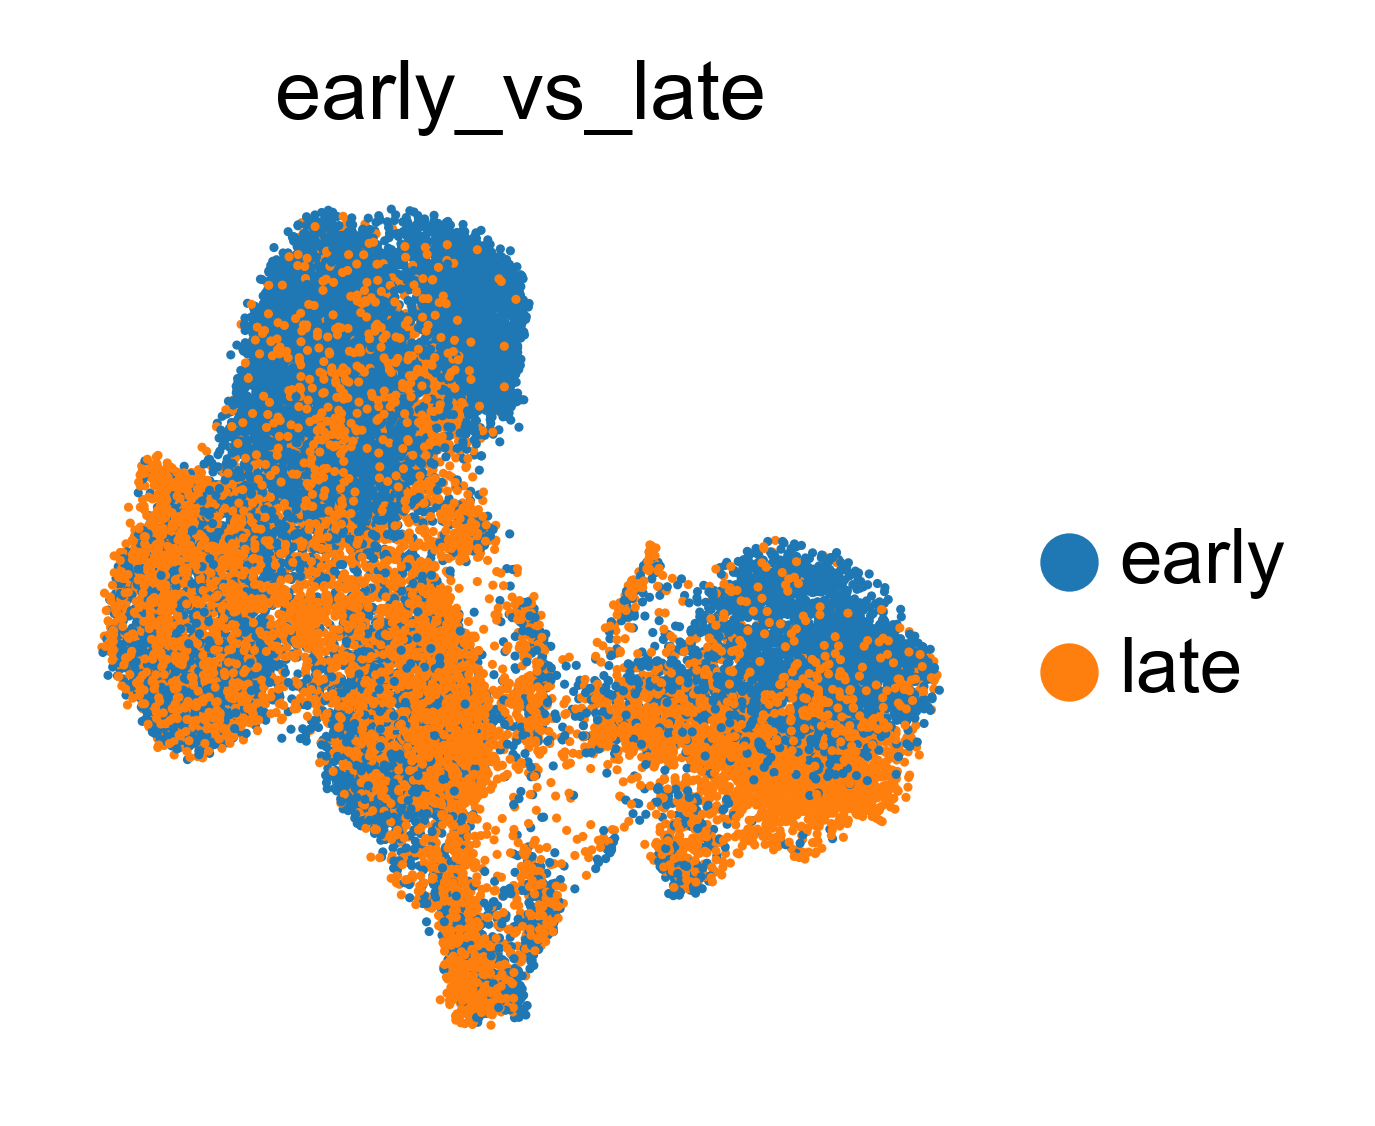

In [49]:
sc.pl.umap(adata,color='early_vs_late')

In [ ]:
umap = adata.obsm['X_umap']

pd.DataFrame(umap).to_csv('Lung.csv')

In [ ]:
focus = scfocus.focus(umap, n=6, max_steps=3, pct_samples=.01).meta_focusing(5)

In [30]:
focus.merge_fp2()

mfp = focus.mfp[0]

for i in range(mfp.shape[1]):
    
    adata.obs[f'f{i}'] = mfp[:, i]

In [ ]:
sc.pl.umap(adata, color=[f'f{i}' for i in range(mfp.shape[1])], cmap='viridis')

In [ ]:
batches = adata.obs['early_vs_late'].cat.categories

lut = dict(zip(batches, adata.uns['early_vs_late_colors']))

with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(1.5,2))
    sns.barplot(y=np.arange(len(batches)),x=np.unique(adata.obs['early_vs_late'], return_counts=True)[1],orient='horizonal',palette=[lut[c] for c in batches],zorder=0)
    ax = plt.gca()
    ax.set_yticklabels(batches, fontdict={'ha':'left'},zorder=10)
    ax.tick_params(axis='y',pad=-4,zorder=10,left=False)
    ax.spines[['right','top']].set_visible(False)

In [54]:
df = pd.DataFrame(mfp, index=adata.obs_names)

df['label'] = adata.obs['early_vs_late']

df1 = df.groupby('label').mean()

df1 = df1[np.argsort(np.argmax(df1, axis=0))]

In [52]:
from sklearn.preprocessing import StandardScaler

df1 = pd.DataFrame(StandardScaler().fit_transform(df1.values), columns=df1.columns,index=df1.index)

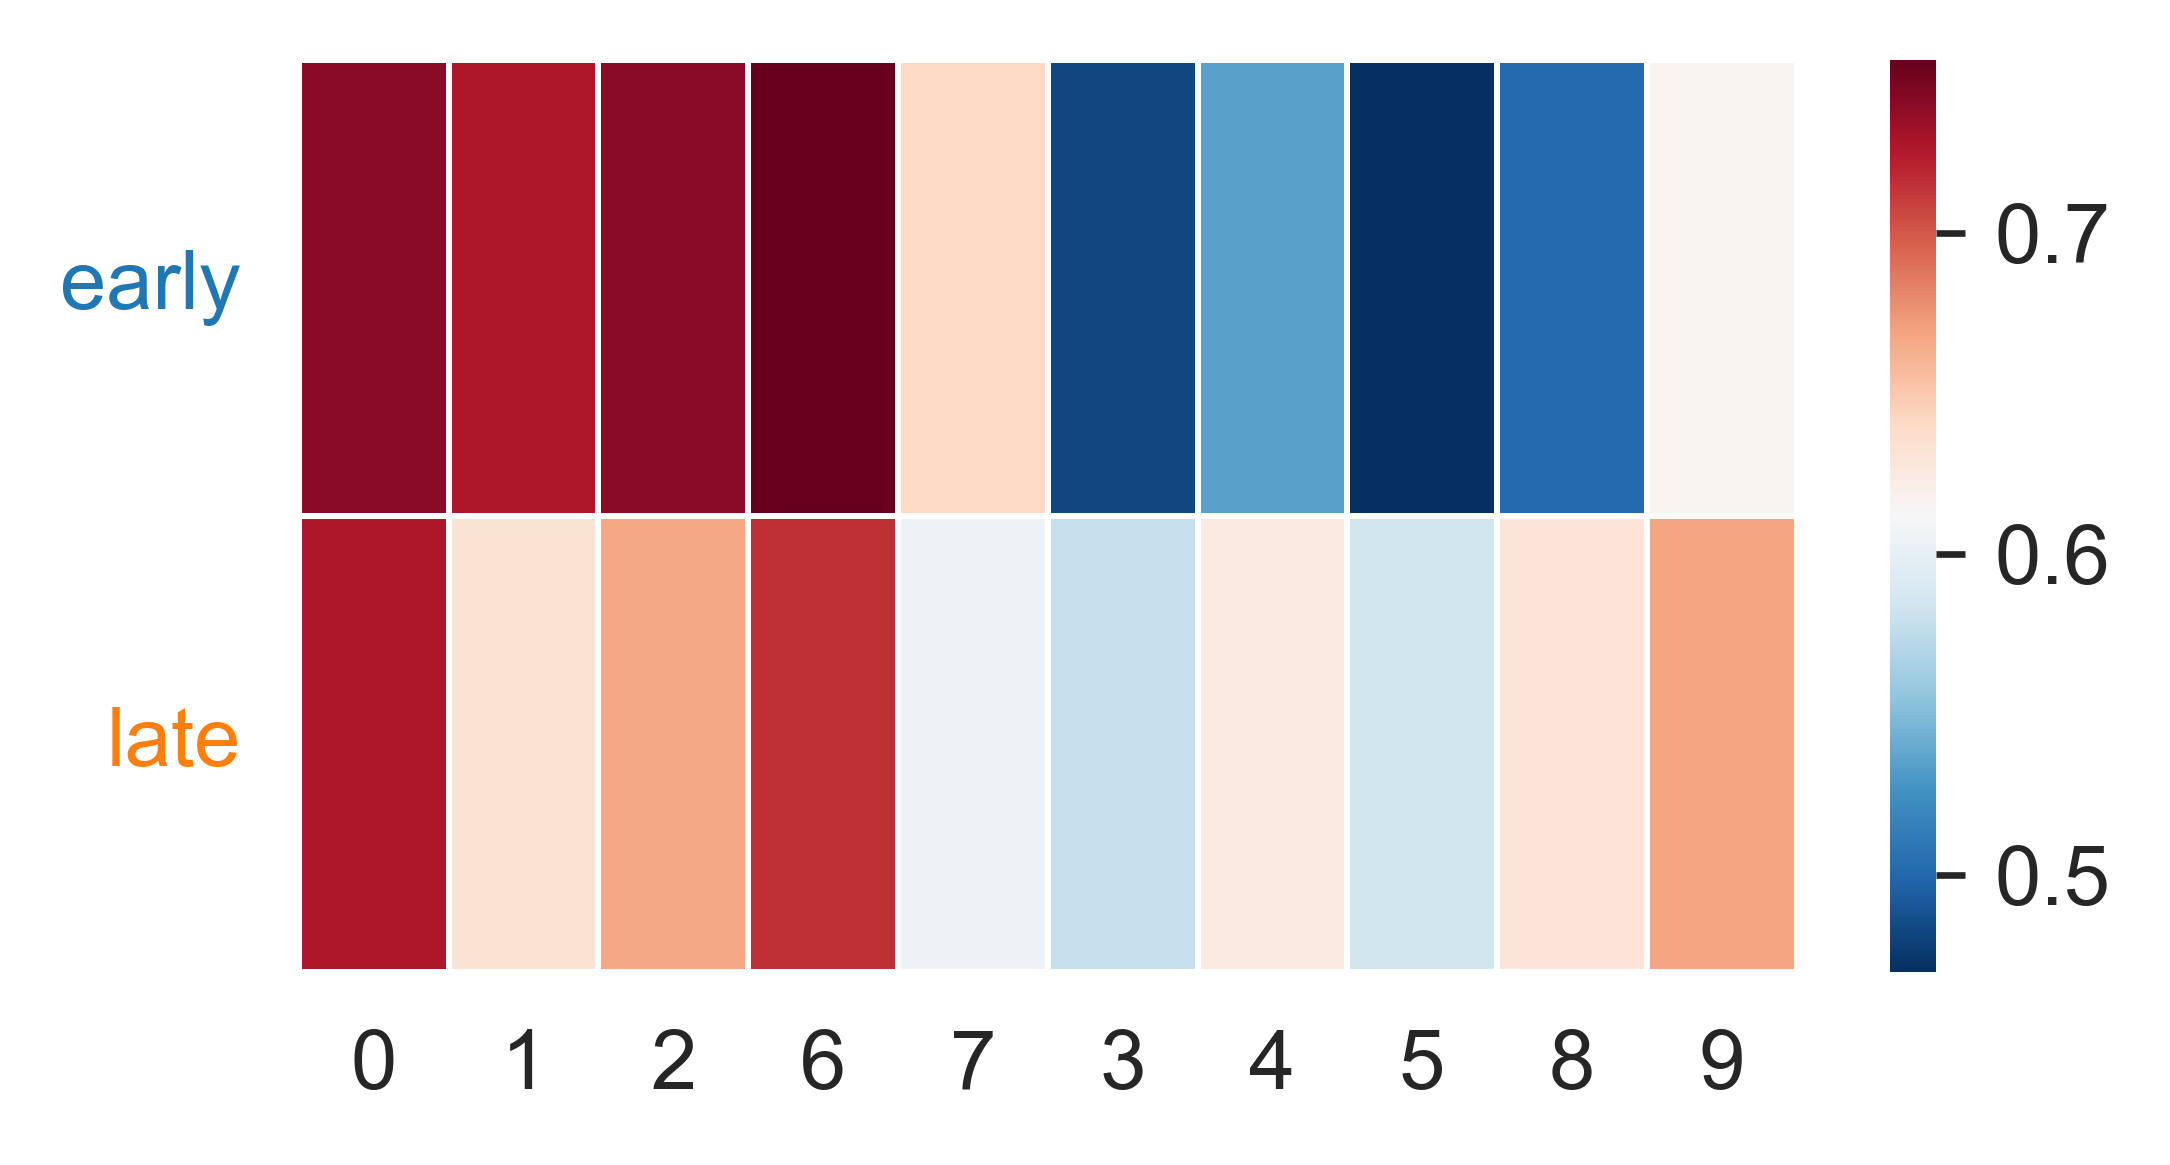

In [55]:
with sns.axes_style('white'):
    fig = plt.figure(figsize=(4,2))
    sns.heatmap(df1, xticklabels=True, lw=.5, cmap='RdBu_r')
    ax = plt.gca()

ax.set_ylabel('')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for tick in ax.get_yticklabels():
    tick.set_color(lut[tick.get_text()])
    tick.set_rotation(0)

In [56]:
adata.obsm['X_focus'] = adata.obs[[f'f{i}' for i in range(mfp.shape[1])]].values

sc.pp.neighbors(adata, use_rep='X_focus')

sc.tl.umap(adata, min_dist=.2)

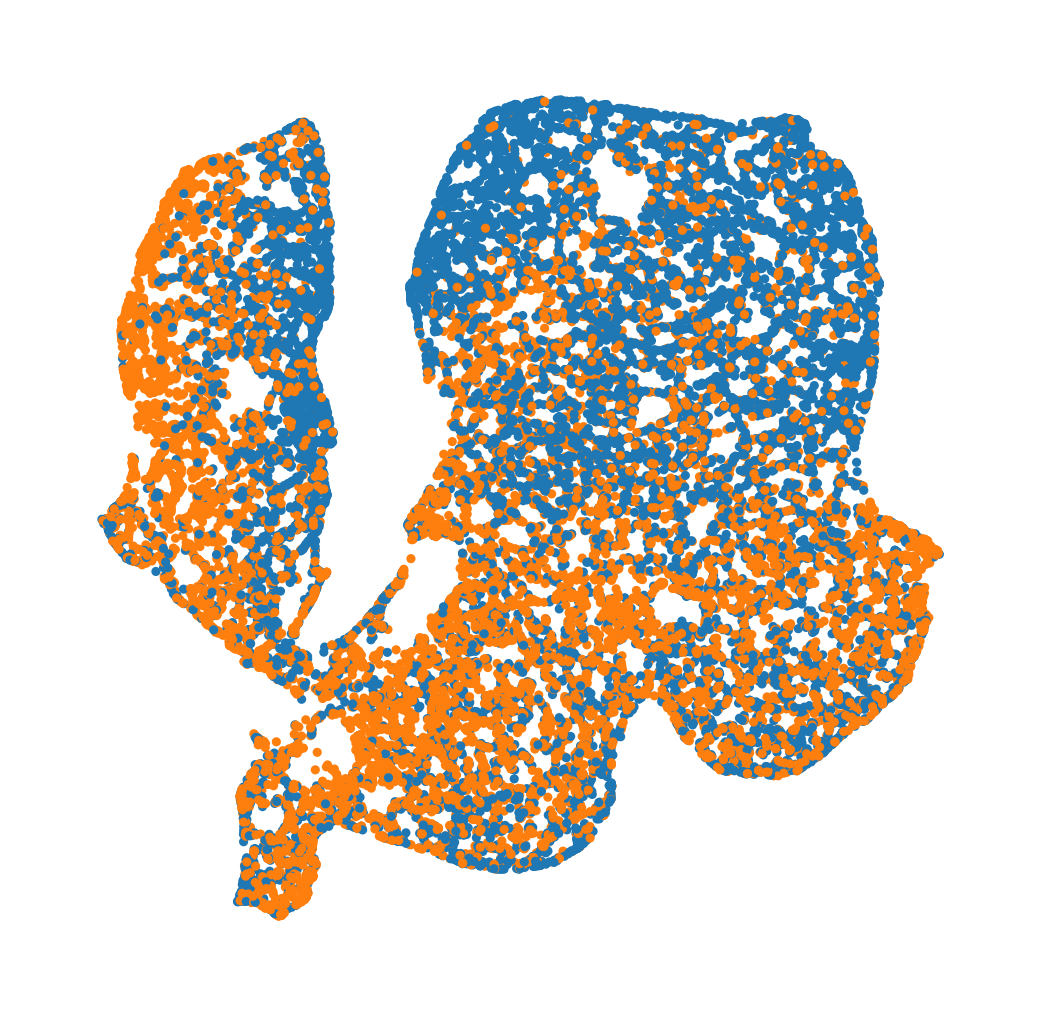

In [58]:
sc.pl.umap(adata, color='early_vs_late', title='', legend_loc=None)

In [59]:
adata.obs['F_1'] = adata.obs[['f0','f1','f2','f6','f7']].mean(axis=1)

adata.obs['F_2'] = adata.obs[['f3','f4','f5','f8','f9']].mean(axis=1)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

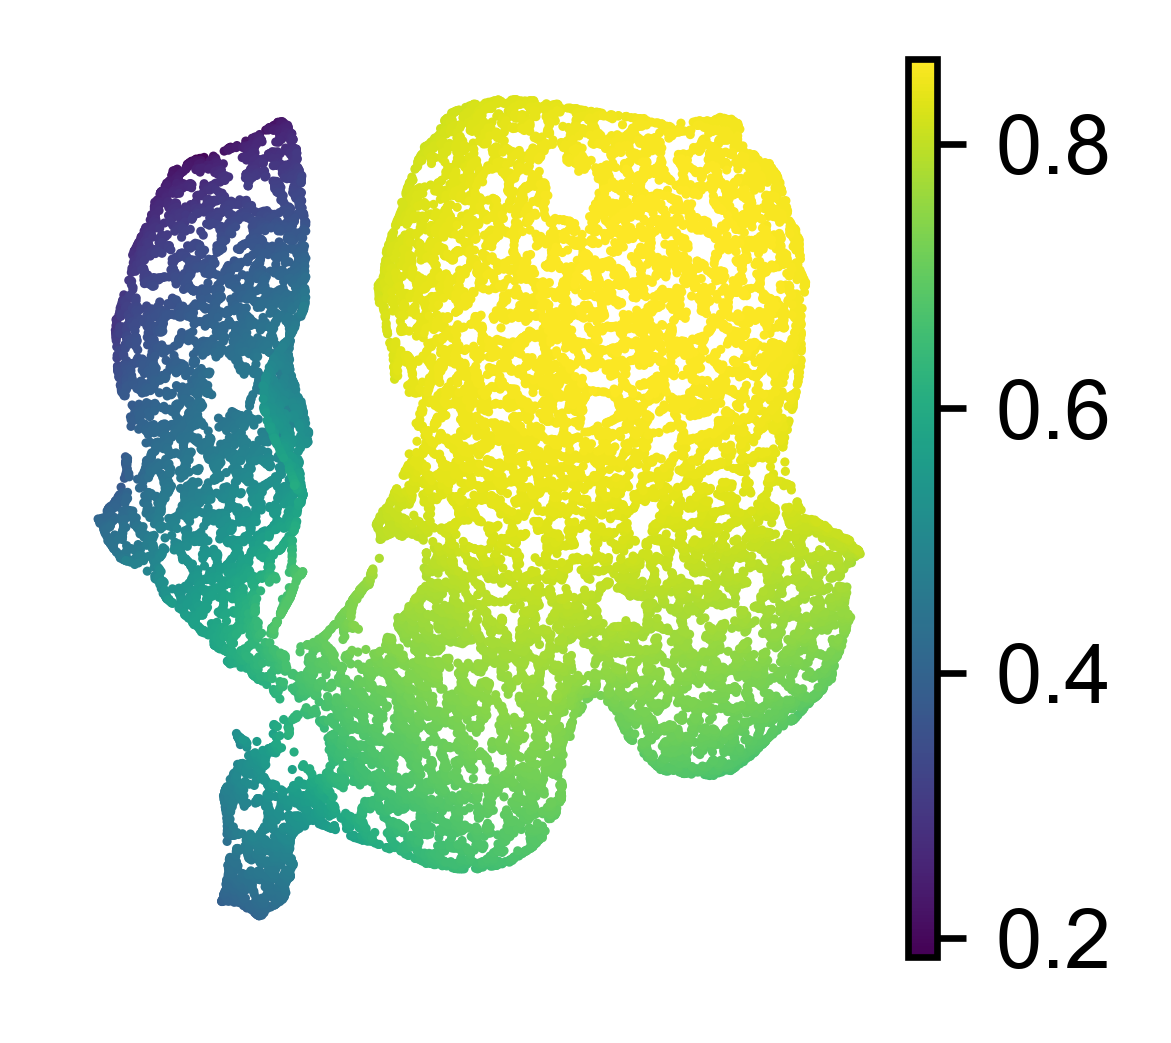

In [60]:
sc.pl.umap(adata, color='F_1', title='', show=False)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

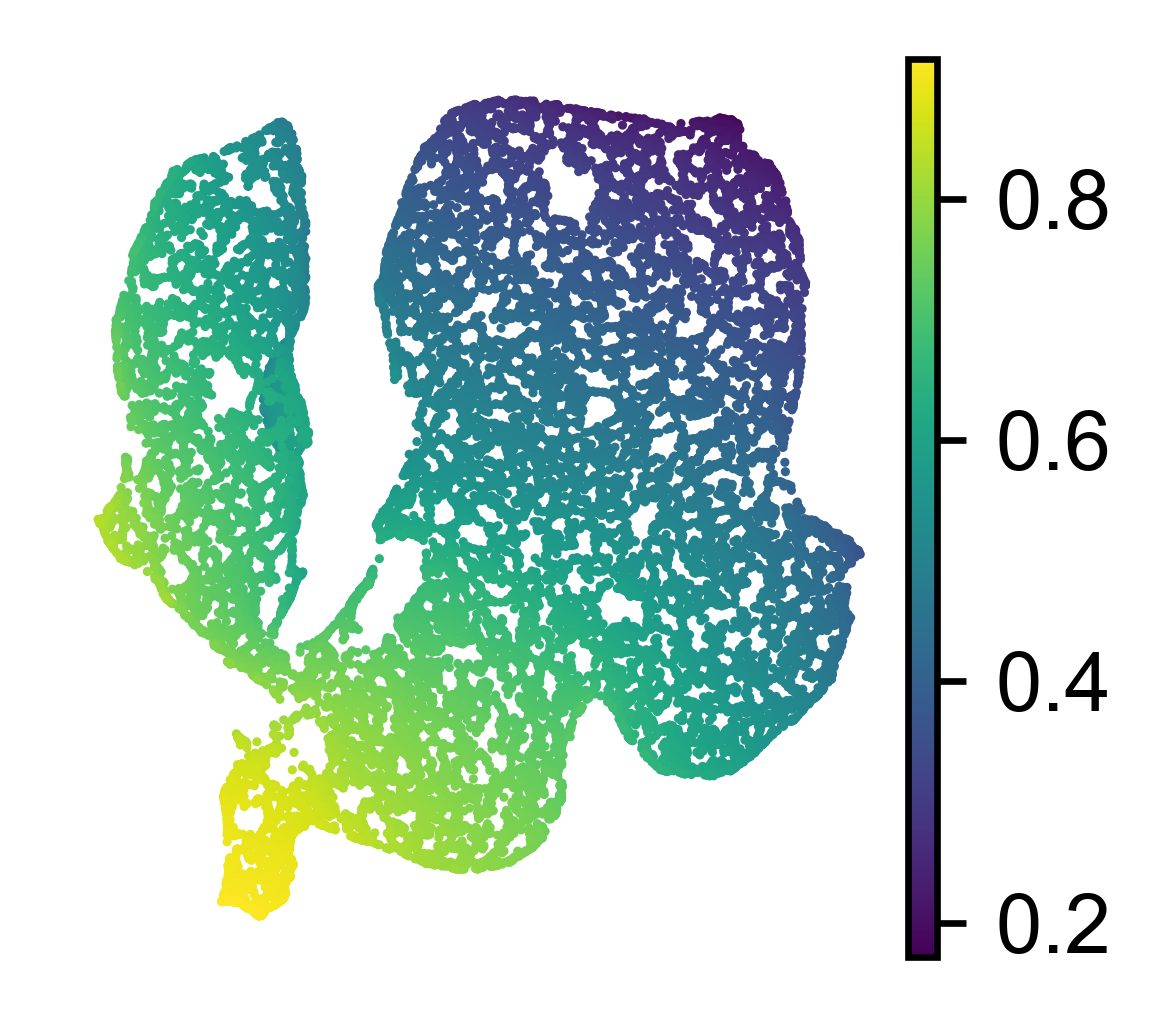

In [61]:
sc.pl.umap(adata, color='F_2', title='', show=False)

In [ ]:
exp = adata[:,adata.var['highly_variable']].to_df()

exp['F_1'] = adata.obs['F_1']
exp['F_2'] = adata.obs['F_2']

corr = np.corrcoef(exp.values.T)

corr = pd.DataFrame(corr, index=exp.columns, columns=exp.columns)

In [64]:
idx1 = corr['F_1'].sort_values(ascending=False).index

idx2 = corr['F_2'].sort_values(ascending=False).index

pd.DataFrame(idx1[1:51]).to_csv('Lung_gs1.csv')

pd.DataFrame(idx2[1:51]).to_csv('Lung_gs2.csv')

In [70]:
idx1[:16]

Index(['F_1', 'Lamp3', 'Ager', 'Hc', 'S100g', 'Elovl1', 'Lpcat1', 'Fasn',
       'Il33', 'Ctsc', 'Cd36', 'Lrg1', 'Sparc', 'Acsl4', 'Lrp2', 'Lgi3'],
      dtype='object', name='index')

In [71]:
idx2[:16]

Index(['F_2', 'Cp', 'Aldh1a1', 'Pigr', 'Lypd2', 'Gsto1', 'Fmo3', 'Ltf', 'Fmo2',
       'Bpifb1', 'Reg3g', 'Tff2', 'Bpifa1', 'Pon1', 'Ppap2b', 'Sult1d1'],
      dtype='object', name='index')

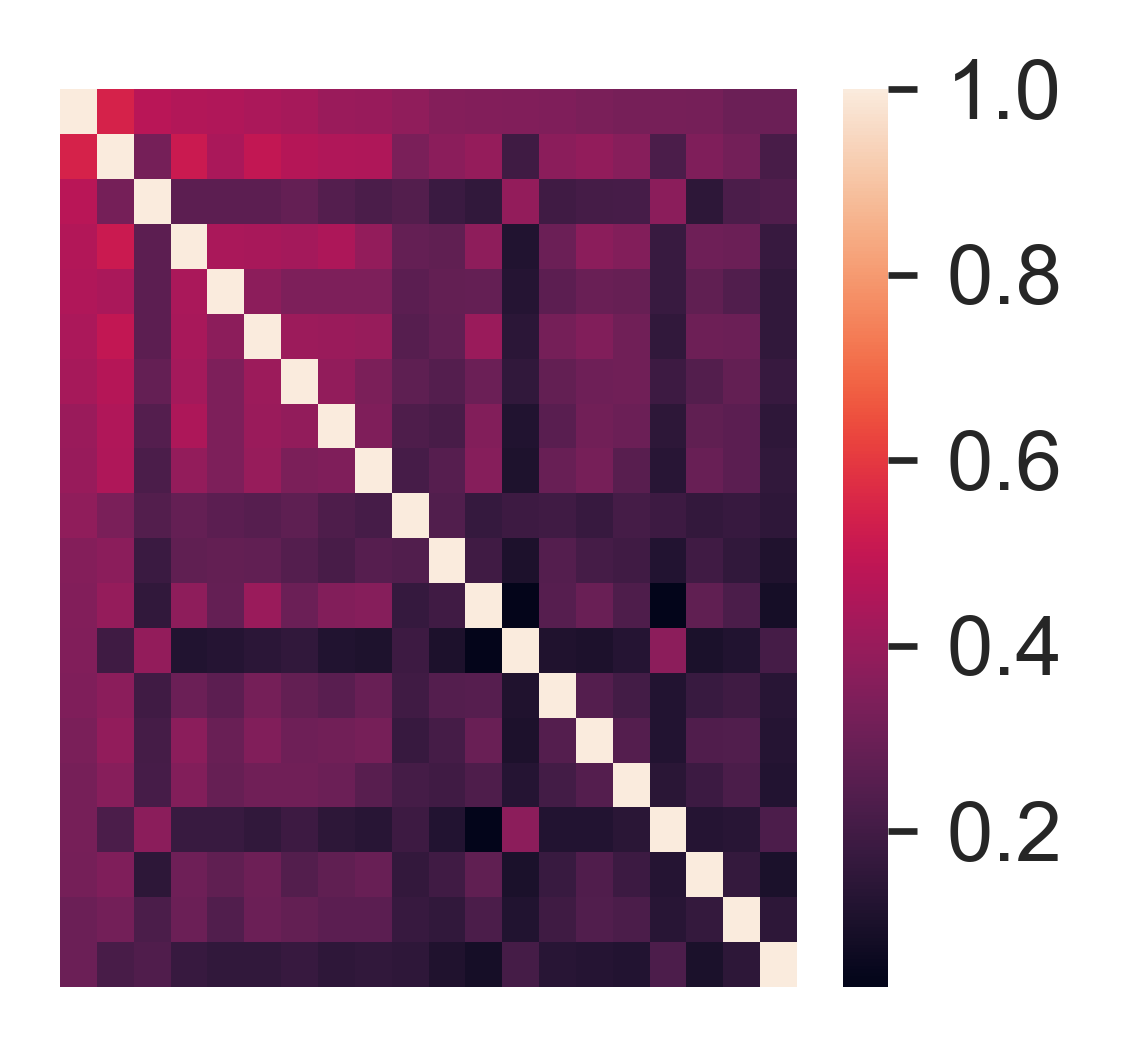

In [66]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx1,idx1].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [72]:
adata.obs['F_1_exp'] = adata[:,['Lamp3', 'Ager', 'Hc', 'S100g', 'Elovl1']].to_df().mean(axis=1)

adata.obs['F_2_exp'] = adata[:,['Cp', 'Aldh1a1', 'Pigr', 'Lypd2', 'Gsto1']].to_df().mean(axis=1)

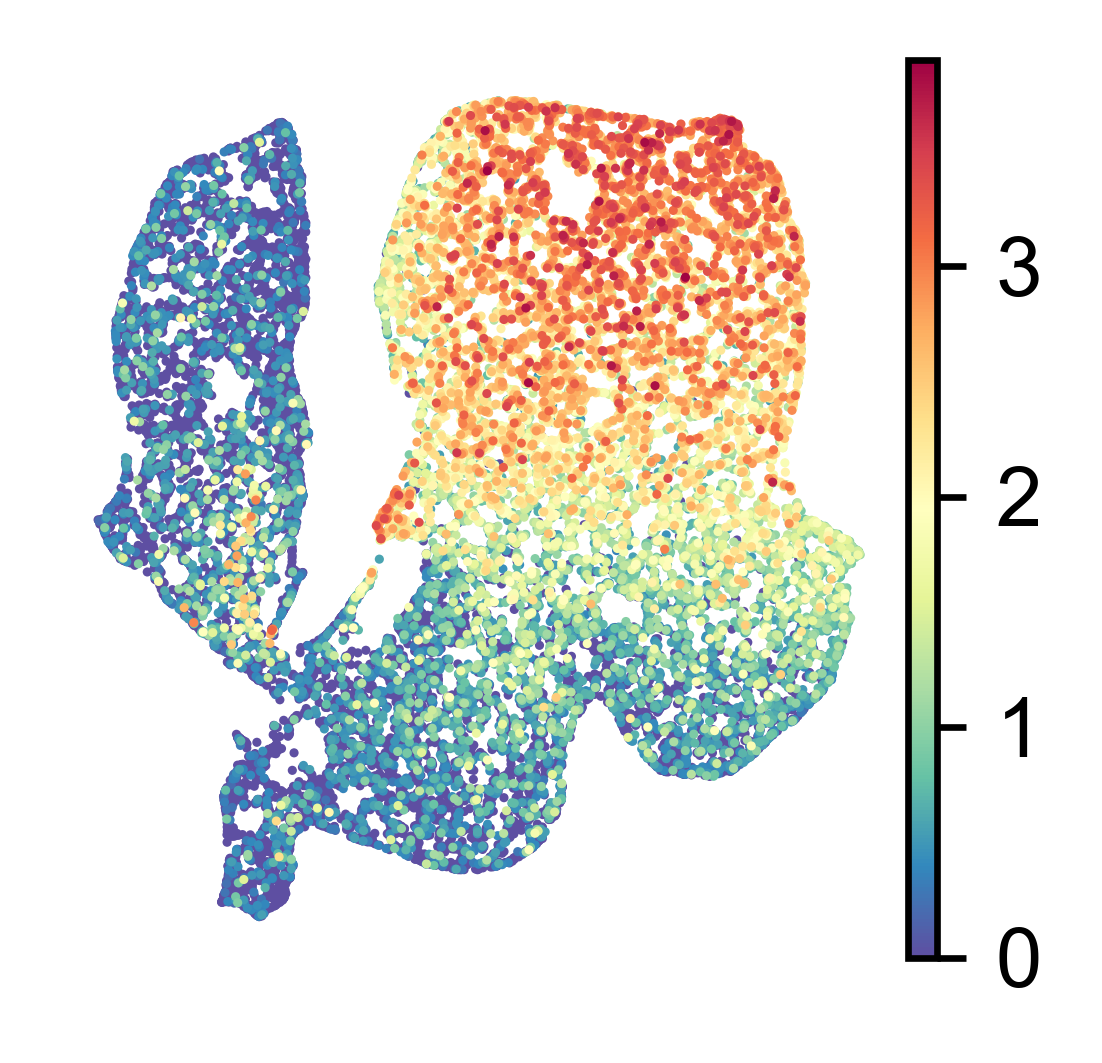

In [73]:
sc.pl.umap(adata, color='F_1_exp',title='', cmap='Spectral_r')

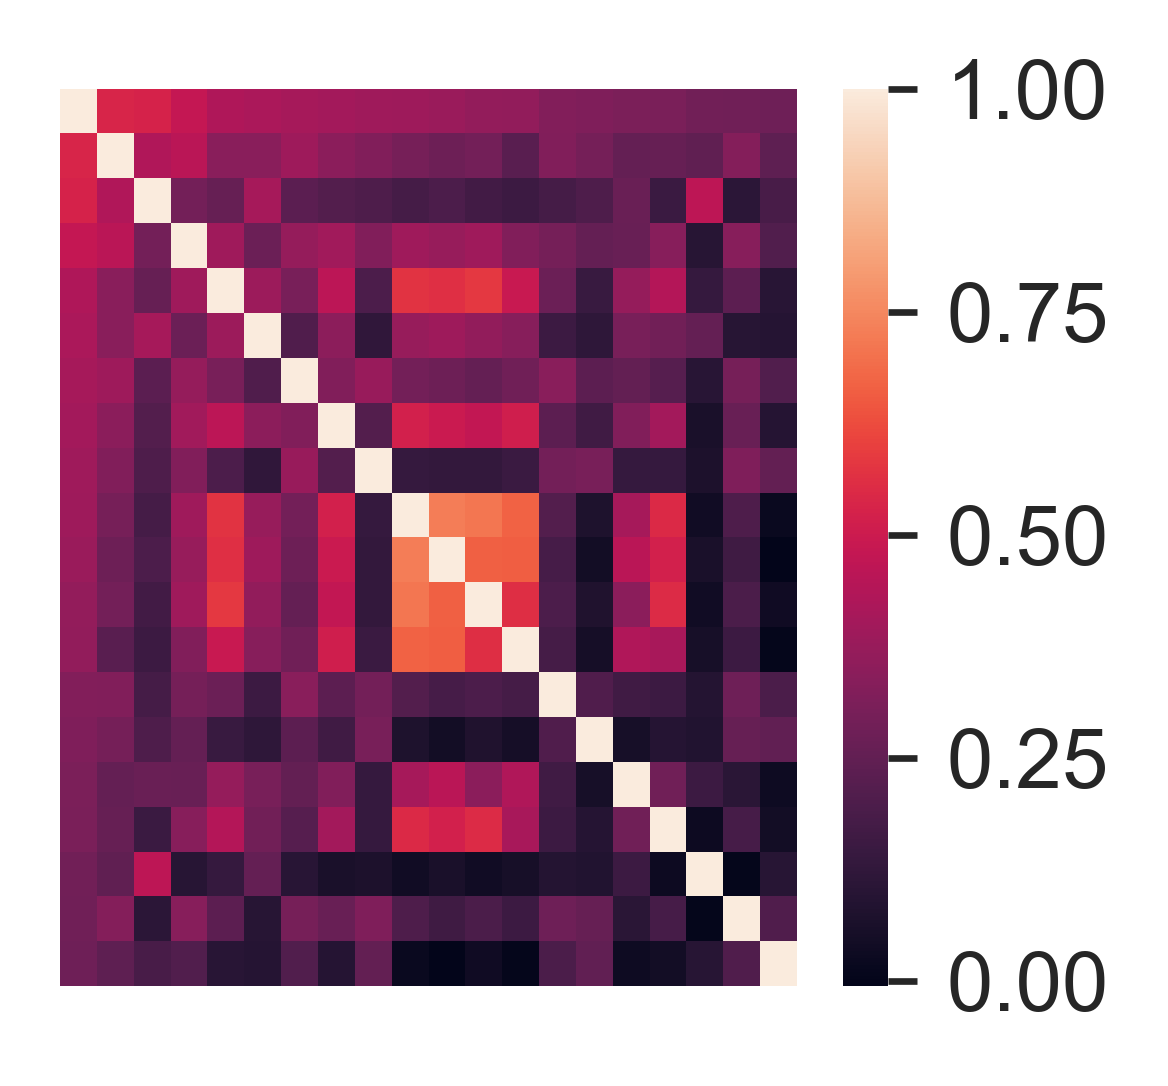

In [67]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx2,idx2].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

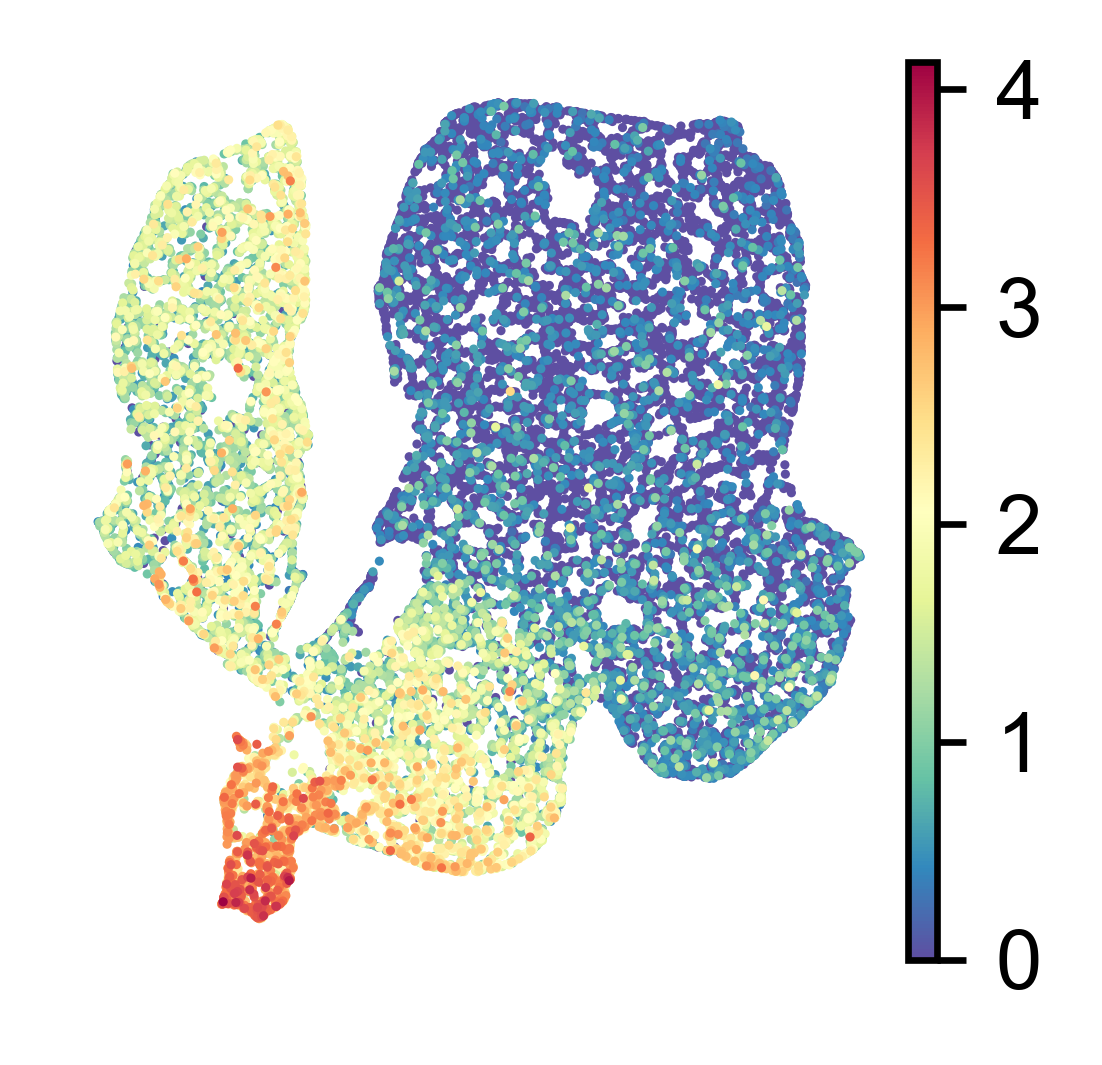

In [74]:
sc.pl.umap(adata, color='F_2_exp',title='', cmap='Spectral_r')

In [77]:
joblib.dump(focus, 'Lung_focus')

['Lung_focus']

In [76]:
joblib.dump(adata, 'Lung')

['Lung']